In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pandas as pd
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib as mpl
mpl.rc("font", family='Droid Sans Fallback', weight="bold")
import matplotlib.pyplot as plt
start, end = '20170104', '20230418'

1. 定义当日收盘价大于过去 3 日平均值, 且当日成交量大于过去 3 日平均值的日期为“放量上涨日”; 当日收盘价小于过去 3 日平均值, 且当日成交量小于过去 3 日平均值的日期为“缩量下跌日”;
2. 分别对每只股票在过去 20 日中 “放量上涨日”的加速换手求和作为因子值,记为放量上涨日加速换手因子, “缩量下跌日” 的加速换手的和为缩量下跌日加速换手因子。

加速换手进行时序标准化处理, 改进步骤为将每日的换手目变化量除以其过去 $\mathrm{n}$ 日换手率变化量的标准差, 其余计算步骤不变, 构造放量上涨日平稳加速换手因子。

将日振幅指标作为波动的代理变量, 定义为当日最高价减最低价, 除以昨日收盘价，计算公式如下:
$$
T R=\frac{\text { High }- \text { Low }}{\text { Preclose }}
$$

对于不同振幅日的加速换手因子定义如下:
1. 定义当日振幅大于过去 3 日平均值的日期为“高振幅日”, 当日振幅小于过去 3 日平均值的日期为“低振幅日”;
2. 对每只股票在过去 20 日中 “高振幅日” 的加速换手和标准化加速换手求和作为因子值, 分别记为高振幅日加速换手因子和高㧼幅日平稳加速换手因子, “低振幅日”因子的计算步棐类似。

挂单㮫大于 100 万元为超大单; 挂单颗 20 万元至 100 万元之间为大单；挂单倾 4 万元到 20 万元之间为中单；挂单倾小于 4 万元为小单。
类似的, 将各类资金流的每日成交情况纳入到因子构成中，计算步骤如下:
1. 以大单交易数据为例, 定义当日个股大单成交额占总成交额的比重大于过去 3 日平均值的日期为“大单成交活跃日”;
2. 对每只股票在过去 20 日中“大单成交活跃日”的加速换手和标准化加速换手求和作为因子值, 分别记为大单成交活跃日加速换手因子和大单成交活跃日平稳加速换手因子，其余类型的资金流的加速换手因子计算步滠相同，不再赀述。

1. 定义当日收盘价大于过去 3 日平均值, 且当日成交量大于过去 3 日平均值的日期为“放量上涨日”; 当日收盘价小于过去 3 日平均值, 且当日成交量小于过去 3 日平均值的日期为“缩量下跌日”;
2. 计算个股日加速换手和当日市场或行业成分股加速换手平均值的差值, 并除以当日成分股加速换手的标准差, 将其作为系数对每日的个股加速换手进行调整,对每只股票在过去 20 日中 “放量上涨日” 的调整后的加速换手和标准化加速换手求和作为因子值, 分别记为平均加速换手偏离因子和平均平稳加速换手偏离因子;
3. 计算个股日加速换手与成分股最小值的差值, 并除以当日成分股日加速换手的标准差, 将其作为系数对每日的个股加速换手进行调整, 记为最小加速换手偏离因子和最小平稳加速换手偏离因子。其中, 最小值取成分股中最小的三个加速换手的平均值。公式如下:

平均加速换手偏离 $=\sum_{i=1}^{20}$ case $_{i \in 0,1} *$ TO_Delta $* \frac{TO_Delta -a v g\left(T O \_D e l t a \_c o n s\right)}{s t d\left(T O \_D e l t a \_c o n s\right)}$
最小加速换手偏离 $=\sum_{i=1}^{20}$ case $_{i \in 0,1} *$ TO_Delta $* \frac{TO_Delta -\min \left(T O \_D e l t a \_c o n s\right)}{s t d\left(T O \_D e l t a \_c o n s\right)}$

要计算的有：           
放量上涨日最小加速换手偏离            
放量上涨日平均加速换手偏离            
放量上涨日最小平稳加速换手偏离           
放量上涨日平均平稳加速换手偏离           
高振幅日最小加速换手偏离             
高振幅日平均加速换手偏离           
高振幅日最小平稳加速换手偏离            
高振幅日平均平稳加速换手偏离           

In [6]:
sw_lst=['申万-国防军工I', '申万-采掘I', '申万-家用电器I', '申万-公用事业I', '申万-通信I', '申万-农林牧渔I', '申万-食品饮料I', '申万-计算机I', '申万-有色金属I', '申万-机械设备I', '申万-交通运输I', '申万-建筑材料I', '申万-银行I', '申万-纺织服装I', '申万-房地产I', '申万-传媒I', '申万-商业贸易I', '申万-综合I', '申万-汽车I', '申万-轻工制造I', '申万-建筑装饰I', '申万-电子I', '申万-非银金融I', '申万-化工I', '申万-休闲服务I', '申万-医药生物I', '申万-电气设备I', '申万-钢铁I','申万-煤炭I', '申万-环保I', '申万-石油石化I', '申万-美容护理I']

In [114]:
def read_data(name,start_day=start,end_day=end):
    if name in ('open', 'close', 'high', 'low'):
        result = (ff.read(name) * ff.read('post') * ff.filter0).loc[ff.filter0.index, start_day:end_day]
    else:
        result = (ff.read(name) * ff.filter0).loc[ff.filter0.index, start_day:end_day]
    return result

def get_event_sub(data_df,N,type):
    if type == '放量' or '上涨' or '活跃' or '高振幅':
        _rolling_data = ff.rolling_window(data_df,N)
        _N_mean = np.nanmean(_rolling_data,axis = -1) # stock ,N_0 - N + 1 
        result_array = np.where(data_df.values[:,(N-1):]>_N_mean,1,np.nan) # stock ,N_0 - N + 1 
    elif type == '缩量' or '下跌' or '低振幅':
        _rolling_data = ff.rolling_window(data_df,N)
        _N_mean = np.nanmean(_rolling_data,axis = -1) # stock ,N_0 - N + 1 
        result_array = np.where(data_df.values[:,(N-1):]<_N_mean,1,np.nan) # stock ,N_0 - N + 1 
    return result_array
    
def get_industry_mean_sub(industry):
    ind = read_data(industry,'factor')
    indus_amount=data_df*ind
    indus_amount_sum=(indus_amount.isna().replace({True:np.nan,False:1}))*(indus_amount.mean())    
    return indus_amount_sum
    
def get_industry_mean(data_array):
    result_lst = []
    for industry in tqdm(sw_lst):
        industry_array = read_data(industry).values
        industry_data_array = industry_array * data_array
        industry_array_mean = np.nanmean(industry_data_array,axis = 0)
        industry_array_mean_all = industry_array_mean*industry_array
        result_lst.append(industry_array_mean_all)
    result_array_all = np.array(result_lst)
    result_array = np.nansum(result_array_all,axis = 0)
    return result_array
    
def get_factor_sub(para):
    # 当日市场或行业成分股加速换手平均值的差值;先使用市场（好算）；再使用行业;算了，都用吧
    _array,_type2 = para
    _array_acc_turn, _array_indus_mean_acc_turn = _array # N_date - N2 + 1,N2
    if _type2 == '平均':
        _res_array = _array_acc_turn*(_array_indus_mean_acc_turn - np.nanmean(_array_indus_mean_acc_turn,axis = 1)[:, np.newaxis])/np.nanstd(_array_indus_mean_acc_turn,axis = 1)[:, np.newaxis]
    elif _type2 == '最小':
        _res_array = _array_acc_turn*(_array_indus_mean_acc_turn - np.nanmin(_array_indus_mean_acc_turn,axis = 1)[:, np.newaxis])/np.nanstd(_array_indus_mean_acc_turn,axis = 1)[:, np.newaxis]
    return _res_array # N_date - N2 + 1,N2
          
class acc_turn(object):
    def __init__(self,start_day,end_day,n = 20):
        self.start = start_day
        self.end = end_day
        _turn = read_data('turnover_rate',start_day,end_day)
        _acc_turn_df = _turn/_turn.shift(1,axis = 1) - 1
        _standered_acc_turn_df = _acc_turn_df.rolling(n,axis = 1).std()
        self.date_lst = _acc_turn_df.columns # N_date
        self.stock_lst = _acc_turn_df.index # N_stock
        self.acc_turn = _acc_turn_df.values # N_stock,N_date
        self.standered_acc_turn = (_acc_turn_df/_standered_acc_turn_df).values # N_stock,N_date
        self.indus_mean_acc_turn = get_industry_mean(self.acc_turn) # N_stock,N_date
        self.indus_mean_standered_acc_turn = get_industry_mean(self.standered_acc_turn) # N_stock,N_date
        self.all_mean_acc_turn = _acc_turn_df.mean().values # N_date
        self.all_mean_standered_acc_turn = _standered_acc_turn_df.mean().values # N_date
        
    def get_factor(self,type1,type2,type3,N1 = 3,N2 = 20):
        # type1: 放量上涨 or 高振幅
        # type2: 最小 or 平均
        # type3: 是否平稳，True or False

        # 事件区域部分
        if type1 == ['放量','上涨']:
            if not hasattr(self, 'rising_heavy_volume_event'):
                if not hasattr(self, 'heavy_volume_event'):
                    _vol = read_data('vol',self.start,self.end)
                    self.heavy_volume_event = get_event_sub(_vol,N1,'放量') # N_stock,N_date - N1 + 1 
                if not hasattr(self, 'rising_event'):
                    _close = read_data('close',self.start,self.end)
                    self.rising_event = get_event_sub(_close,N1,'上涨') # N_stock,N_date - N1 + 1 
                self.rising_heavy_volume_event = self.heavy_volume_event * self.rising_event# N_stock,N_date - N1 + 1 
            _event = ff.rolling_window(self.rising_heavy_volume_event,N2) # N_stock,N_date - N1 - N2 + 2,N2
        elif type1 == '高振幅':
            if not hasattr(self, 'high_amplitude_event'):
                _close = read_data('close',self.start,self.end)
                _high = read_data('high',self.start,self.end)
                _low = read_data('low',self.start,self.end)
                _TR = (_high - _low)/_close.shift(1,axis = 1)
                self.high_amplitude_event = get_event_sub(_TR,N1,'高振幅') # N_stock,N_date - N1 + 1 
            _event = ff.rolling_window(self.high_amplitude_event,N2) # N_stock,N_date - N1 - N2 + 2,N2

        # 因子计算部分
        # 平稳
        if type3:
            _rolling_standered_acc_turn = ff.rolling_window(self.standered_acc_turn,N2) # N_stock,N_date - N2 + 1,N2
            _rolling_indus_mean_standered_acc_turn = ff.rolling_window(self.indus_mean_standered_acc_turn,N2) # N_stock,N_date - N2 + 1,N2
            para_lst = [((_rolling_standered_acc_turn[i,:,:],_rolling_indus_mean_standered_acc_turn[i,:,:]),type2) for i in range(len(self.stock_lst))] # N_stock
            if type2 == '最小':
                if not hasattr(self, 'min_standered_factor_before'):
                    with Pool(24) as p:
                        _res_lst = list(tqdm(p.imap(get_factor_sub,para_lst),total = len(self.stock_lst))) # N_stock,N_date - N2 + 1,N2
                    self.min_standered_factor_before = np.array(_res_lst) # N_stock,N_date - N2 + 1,N2
                _factor_without_event = self.min_standered_factor_before[:,(N1-1):,:] # N_stock,N_date - N1 - N2 + 2,N2
            elif type2 == '平均':
                if not hasattr(self, 'mean_standered_factor_before'):
                    with Pool(24) as p:
                        _res_lst = list(tqdm(p.imap(get_factor_sub,para_lst),total = len(self.stock_lst))) # N_stock,N_date - N2 + 1,N2
                    self.mean_standered_factor_before = np.array(_res_lst) # N_stock,N_date - N2 + 1,N2
                _factor_without_event = self.mean_standered_factor_before[:,(N1-1):,:] # N_stock,N_date - N1 - N2 + 2,N2     
        # 非平稳
        if not type3:
            _rolling_acc_turn = ff.rolling_window(self.acc_turn,N2) # N_stock,N_date - N2 + 1,N2
            _rolling_indus_acc_turn = ff.rolling_window(self.indus_mean_acc_turn,N2) # N_stock,N_date - N2 + 1,N2
            para_lst = [((_rolling_acc_turn[i,:,:],_rolling_indus_acc_turn[i,:,:]),type2) for i in range(len(self.stock_lst))] # N_stock
            if type2 == '最小':
                if not hasattr(self, 'min_factor_before'):
                    with Pool(24) as p:
                        _res_lst = list(tqdm(p.imap(get_factor_sub,para_lst),total = len(self.stock_lst))) # N_stock,N_date - N2 + 1,N2
                    self.min_factor_before = np.array(_res_lst) # N_stock,N_date - N2 + 1,N2
                _factor_without_event = self.min_factor_before[:,(N1-1):,:] # N_stock,N_date - N1 - N2 + 2,N2
            elif type2 == '平均':
                if not hasattr(self, 'mean_factor_before'):
                    with Pool(24) as p:
                        _res_lst = list(tqdm(p.imap(get_factor_sub,para_lst),total = len(self.stock_lst))) # N_stock,N_date - N2 + 1,N2
                    self.mean_factor_before = np.array(_res_lst) # N_stock,N_date - N2 + 1,N2
                _factor_without_event = self.mean_factor_before[:,(N1-1):,:] # N_stock,N_date - N1 - N2 + 2,N2

        # 组合部分
        _factor_array = np.nansum(_event * _factor_without_event,axis = -1) # N_stock,N_date - N1 - N2 + 2
        _factor_array[_factor_array == 0] = np.nan
        _result = pd.DataFrame(_factor_array,columns = self.date_lst[N1+N2-2:],index = self.stock_lst)
        return _result       

# 对称正交后进行等权合成
def symmetric(matrix):
    _len = matrix.shape[1]
    result = np.array([np.nan] * _len)
    df = pd.DataFrame(matrix.T)
    df_c = df.dropna()
    index_c = df_c.index
    F = np.array(df_c,dtype=np.float64)
    # 求$M_{K*K}$的特征值和特征向量
    Lambda,Q = np.linalg.eigh(np.dot(F.T, F))
    D = np.diag(Lambda ** (-0.5))
    D = np.where(np.isnan(D), 0, D)
    Fhat = np.dot(F,Q)
    Fhat = np.dot(Fhat,D)
    Fhat = np.dot(Fhat,Q.T)
    for i in range(Fhat.shape[1]):
        Fhat[:,i] = Fhat[:,i] / np.sqrt(np.dot(Fhat[:,i], Fhat[:,i]))
    sum_Fhat = np.nansum(Fhat,axis = 1)
    result[index_c] = sum_Fhat
    return result # N_stock

def get_final_factor(n = 20, N1 = 3, N2 = 20,start = '20170104', end = '20230418'):
    final_example = acc_turn(start, end, n)
    min_rising_heavy_volume_factor = final_example.get_factor(['放量','上涨'],'最小',False,N1,N2) # 放量上涨日最小加速换手偏离
    mean_rising_heavy_volume_factor = final_example.get_factor(['放量','上涨'],'平均',False,N1,N2) # 放量上涨日平均加速换手偏离
    min_standered_rising_heavy_volume_factor = final_example.get_factor(['放量','上涨'],'最小',True,N1,N2) # 放量上涨日最小平稳加速换手偏离
    mean_standered_rising_heavy_volume_factor = final_example.get_factor(['放量','上涨'],'平均',True,N1,N2) # 放量上涨日平均平稳加速换手偏离
    min_high_amplitude_factor = final_example.get_factor('高振幅','最小',False,N1,N2) # 高振幅日最小加速换手偏离
    mean_high_amplitude_factor = final_example.get_factor('高振幅','平均',False,N1,N2) # 高振幅日平均加速换手偏离
    min_standered_high_amplitude_factor = final_example.get_factor('高振幅','最小',True,N1,N2) # 高振幅日最小平稳加速换手偏离
    mean_standered_high_amplitude_factor = final_example.get_factor('高振幅','平均',True,N1,N2) # 高振幅日平均平稳加速换手偏离
    date_lst = final_example.date_lst[N1+N2-2:]
    stock_lst = final_example.stock_lst
    matrix_lst = [np.stack((min_rising_heavy_volume_factor.values[:,i], mean_rising_heavy_volume_factor.values[:,i],min_standered_rising_heavy_volume_factor.values[:,i],mean_standered_rising_heavy_volume_factor.values[:,i],min_high_amplitude_factor.values[:,i],mean_high_amplitude_factor.values[:,i],min_standered_high_amplitude_factor.values[:,i],mean_standered_high_amplitude_factor.values[:,i]), axis=0) for i in range(len(date_lst))]
    with Pool(24) as p:
        res_lst = list(tqdm(p.imap(symmetric,matrix_lst),total = len(date_lst))) # N_date_lst,N_stock
    final_factor = pd.DataFrame(res_lst,columns = stock_lst,index = date_lst).T
    return final_factor, min_rising_heavy_volume_factor, mean_rising_heavy_volume_factor, min_standered_rising_heavy_volume_factor, mean_standered_rising_heavy_volume_factor, min_high_amplitude_factor, mean_high_amplitude_factor, min_standered_high_amplitude_factor, mean_standered_high_amplitude_factor

In [115]:
final_factor, min_rising_heavy_volume_factor, mean_rising_heavy_volume_factor, min_standered_rising_heavy_volume_factor, mean_standered_rising_heavy_volume_factor, min_high_amplitude_factor, mean_high_amplitude_factor, min_standered_high_amplitude_factor, mean_standered_high_amplitude_factor = get_final_factor()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1507/1507 [00:29<00:00, 51.83it/s]


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


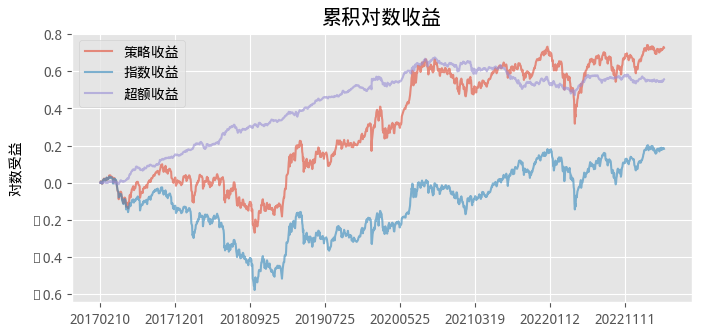

,指数收益,超额收益,策略收益
年化收益率,0.030,0.093,0.121
年化波动率,0.214,0.079,0.237
夏普率,0.141,1.172,0.510
最大回撤,-0.612,-0.203,-0.415
收益回撤比,0.049,0.455,0.291
胜率,0.541,0.521,0.549
盈亏比,0.870,1.138,0.898


In [117]:
# 同系列指标选择
p_up = ff.run(min_rising_heavy_volume_factor.shift(1,axis = 1) * ff.filter0, positions=100, period=1, fees=0)

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


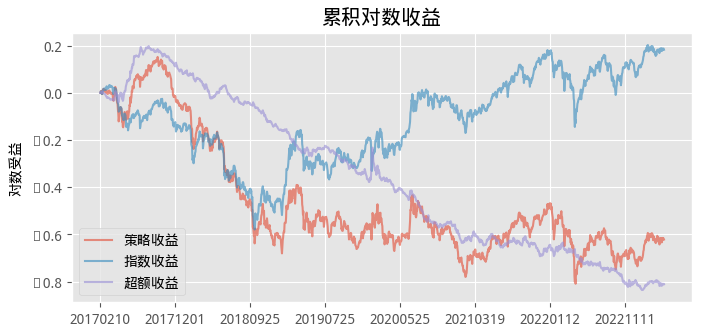

,指数收益,超额收益,策略收益
年化收益率,0.030,-0.135,-0.103
年化波动率,0.214,0.095,0.229
夏普率,0.141,-1.419,-0.450
最大回撤,-0.612,-1.033,-0.961
收益回撤比,0.049,-0.130,-0.107
胜率,0.541,0.426,0.504
盈亏比,0.870,1.046,0.909


In [125]:
p_up = ff.run(-mean_rising_heavy_volume_factor.shift(1,axis = 1) * ff.filter0, positions=100, period=1, fees=0)

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


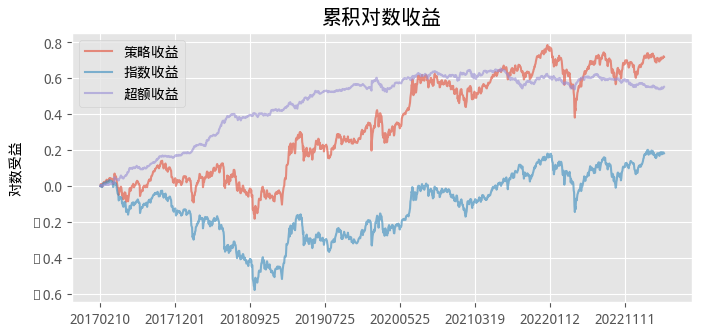

,指数收益,超额收益,策略收益
年化收益率,0.030,0.092,0.120
年化波动率,0.214,0.075,0.238
夏普率,0.141,1.230,0.502
最大回撤,-0.612,-0.117,-0.404
收益回撤比,0.049,0.783,0.296
胜率,0.541,0.523,0.556
盈亏比,0.870,1.140,0.873


In [119]:
p_up = ff.run(min_standered_rising_heavy_volume_factor.shift(1,axis = 1) * ff.filter0, positions=100, period=1, fees=0)

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


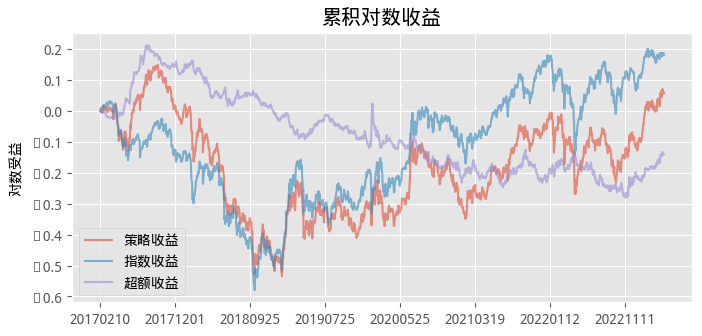

,指数收益,超额收益,策略收益
年化收益率,0.030,-0.023,0.010
年化波动率,0.214,0.107,0.228
夏普率,0.141,-0.218,0.042
最大回撤,-0.612,-0.494,-0.685
收益回撤比,0.049,-0.047,0.014
胜率,0.541,0.474,0.515
盈亏比,0.870,1.067,0.949


In [126]:
p_up = ff.run(-mean_standered_rising_heavy_volume_factor.shift(1,axis = 1) * ff.filter0, positions=100, period=1, fees=0)

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


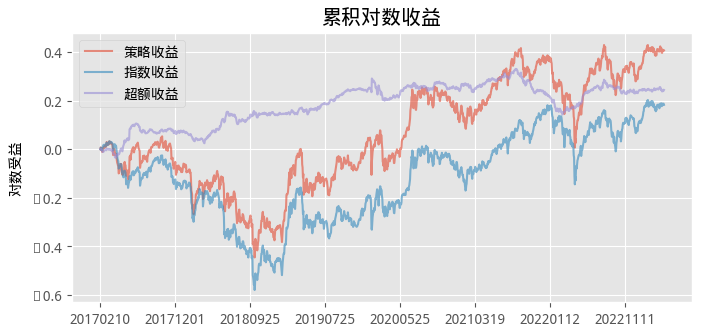

,指数收益,超额收益,策略收益
年化收益率,0.030,0.040,0.067
年化波动率,0.214,0.071,0.240
夏普率,0.141,0.571,0.281
最大回撤,-0.612,-0.188,-0.498
收益回撤比,0.049,0.216,0.135
胜率,0.541,0.507,0.552
盈亏比,0.870,1.080,0.850


In [121]:
p_up = ff.run(min_high_amplitude_factor.shift(1,axis = 1) * ff.filter0, positions=100, period=1, fees=0)

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


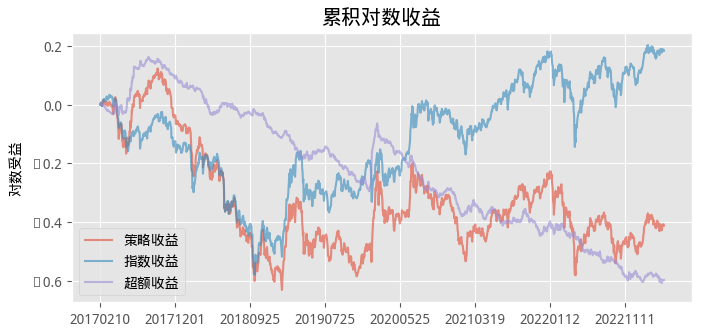

,指数收益,超额收益,策略收益
年化收益率,0.030,-0.099,-0.068
年化波动率,0.214,0.087,0.230
夏普率,0.141,-1.137,-0.298
最大回撤,-0.612,-0.770,-0.754
收益回撤比,0.049,-0.129,-0.091
胜率,0.541,0.426,0.510
盈亏比,0.870,1.098,0.911


In [127]:
p_up = ff.run(-mean_high_amplitude_factor.shift(1,axis = 1) * ff.filter0, positions=100, period=1, fees=0)

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


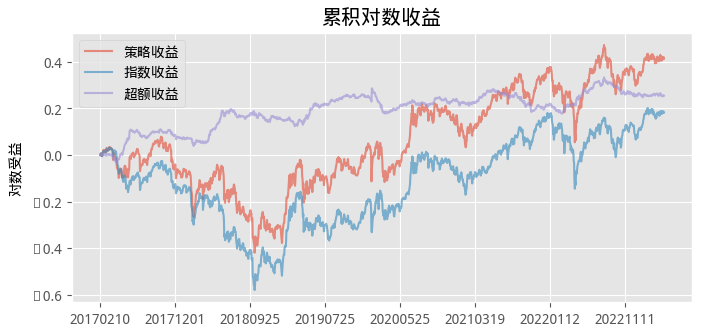

,指数收益,超额收益,策略收益
年化收益率,0.030,0.042,0.069
年化波动率,0.214,0.068,0.242
夏普率,0.141,0.621,0.283
最大回撤,-0.612,-0.108,-0.498
收益回撤比,0.049,0.390,0.138
胜率,0.541,0.511,0.548
盈亏比,0.870,1.068,0.864


In [123]:
p_up = ff.run(min_standered_high_amplitude_factor.shift(1,axis = 1) * ff.filter0, positions=100, period=1, fees=0)

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


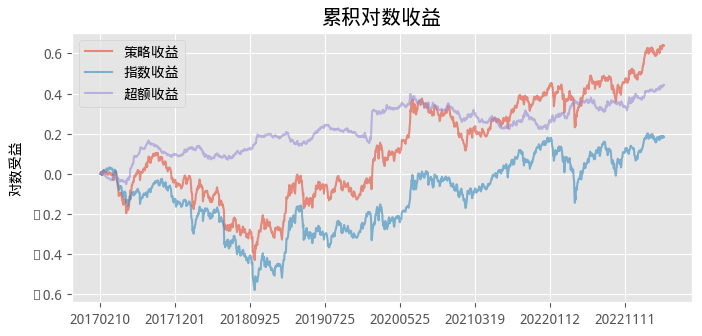

,指数收益,超额收益,策略收益
年化收益率,0.030,0.074,0.106
年化波动率,0.214,0.094,0.224
夏普率,0.141,0.780,0.474
最大回撤,-0.612,-0.176,-0.535
收益回撤比,0.049,0.418,0.198
胜率,0.541,0.492,0.537
盈亏比,0.870,1.183,0.935


In [128]:
p_up = ff.run(-mean_standered_high_amplitude_factor.shift(1,axis = 1) * ff.filter0, positions=100, period=1, fees=0)

In [134]:
final_factor_rank = min_rising_heavy_volume_factor.rank() - mean_rising_heavy_volume_factor.rank() + min_standered_rising_heavy_volume_factor.rank() - mean_standered_rising_heavy_volume_factor.rank() + min_high_amplitude_factor.rank() - mean_high_amplitude_factor.rank() + min_standered_high_amplitude_factor.rank() - mean_standered_high_amplitude_factor.rank()

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


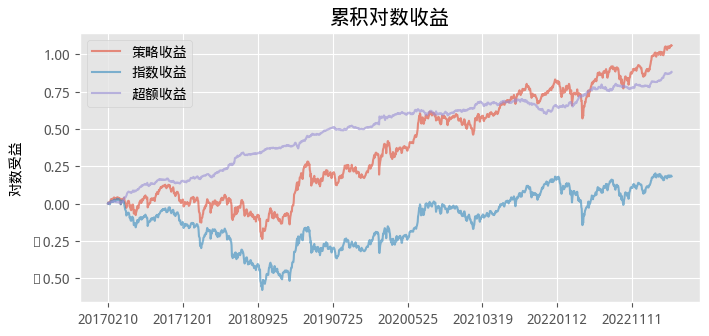

,指数收益,超额收益,策略收益
年化收益率,0.030,0.146,0.176
年化波动率,0.214,0.069,0.229
夏普率,0.141,2.137,0.767
最大回撤,-0.612,-0.101,-0.364
收益回撤比,0.049,1.454,0.483
胜率,0.541,0.554,0.564
盈亏比,0.870,1.172,0.883


In [135]:
p_up = ff.run(final_factor_rank.shift(1,axis = 1) * ff.filter0, positions=100, period=1, fees=0)

In [152]:
# 标准化后进行等权合成
def scaled(matrix):
    _mean_matrix = np.nanmean(matrix,axis = 0) # 8
    _std_matrix = np.nanstd(matrix,axis = 0) # 8
    _result_all_matrix = (matrix - _mean_matrix[np.newaxis,:])/_std_matrix[np.newaxis,:]
    _weight = np.array([1,-1,1,-1,1,-1,1,-1])
    _result_all_matrix_weight = _result_all_matrix * _weight[:,np.newaxis]
    # _result_array = np.nanmean(_result_all_matrix_weight,axis = 0)
    _result_array = np.nanmean(_result_all_matrix,axis = 0)
    return _result_array # N_stock

In [153]:
matrix_lst = [np.stack((min_rising_heavy_volume_factor.values[:,i], mean_rising_heavy_volume_factor.values[:,i],min_standered_rising_heavy_volume_factor.values[:,i],mean_standered_rising_heavy_volume_factor.values[:,i],min_high_amplitude_factor.values[:,i],mean_high_amplitude_factor.values[:,i],min_standered_high_amplitude_factor.values[:,i],mean_standered_high_amplitude_factor.values[:,i]), axis=0) for i in range(len(date_lst))]
with Pool(24) as p:
    res_lst = list(tqdm(p.imap(scaled,matrix_lst),total = len(date_lst))) # N_date_lst,N_stock
final_factor = pd.DataFrame(res_lst,columns = stock_lst,index = date_lst).T

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1507/1507 [00:01<00:00, 1025.24it/s]


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


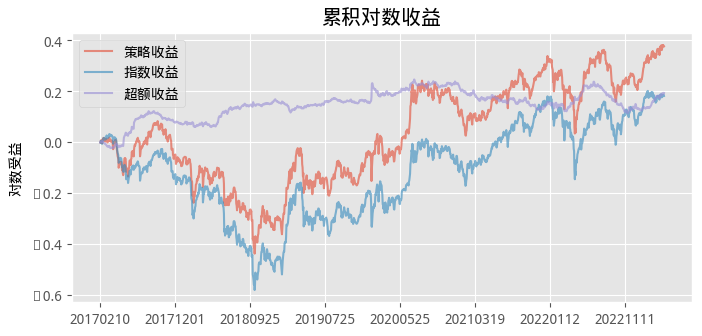

,指数收益,超额收益,策略收益
年化收益率,0.030,0.032,0.063
年化波动率,0.214,0.059,0.222
夏普率,0.141,0.542,0.283
最大回撤,-0.612,-0.132,-0.520
收益回撤比,0.049,0.244,0.120
胜率,0.541,0.476,0.553
盈亏比,0.870,1.214,0.848


In [159]:
p_up = ff.run(final_factor.shift(1,axis = 1) * ff.filter0, positions=100, period=1, fees=0)

In [160]:
import os

In [161]:
os.getcwd()

'/home/wangs/rs/rc/加速换手因子'